In [1]:
import os

In [2]:
import pickle

In [3]:
random_seed = 42

In [4]:
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [5]:
import csv

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [8]:
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
from tqdm import tqdm

In [10]:
from sklearn.metrics import classification_report

In [11]:
from scipy import stats

In [12]:
output_collections_list = []
for idx in range(0, 9000+1, 1000):
    with open("saved/score/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
#         print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


10000

In [13]:
data = []
for i in output_collections_list:
    data.append([i['index'], 
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], i['theta'], 
                 i['sentence'], i['label'], i['prediction'], i['prob'],
                 i['tokens'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['sample_index', 
                                   'influence_prime', 
                                   'influence', 
                                   'diff', 'theta', 
                                   'sentence', 'label', 'prediction', 'prob', 
                                   'tokens', 'attributions'
                                  ])

df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [14]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

0

In [15]:
df_0.loc[drop_index, 'influence'] = 0.0

In [16]:
df_0['rank'] = df_0['influence'].rank(method='first', ascending=False)

In [17]:
df_0['rank'].head()

0    3804.0
1    3104.0
2    2241.0
3    285.0 
4    4099.0
Name: rank, dtype: float64

In [18]:
mem_list = []
for i in range(0, 100, 10):
    k = int(len(df_0)*i/100)
    print(k)
    mem_list.append(df_0[df_0['rank']==k+1]['influence'].values[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [19]:
mem_list

[19.176786422729492,
 4.863029956817627,
 3.5159220695495605,
 2.2574429512023926,
 1.1523351669311523,
 0.5310436487197876,
 0.20275020599365234,
 0.07580536603927612,
 0.025483503937721252,
 0.006323505192995071]

In [20]:
def read_report(output_path, order, percentage, seed, epoch, split):
    df = pd.read_csv(os.path.join(output_path, order, percentage, seed, "report/{}_{}.csv".format(epoch-1, split)))
    return df

In [21]:
original = []
for seed in [0, 1, 2, 3, 42]:
    df = read_report('saved', 'random', str(0), str(seed), 5, 'test')
    original.append(df.loc[10][1])
original

[0.7492, 0.7494, 0.7489, 0.7489, 0.7515]

In [22]:
percentage_list = [
    10, 
    20, 
    30, 
    40, 
    50
                  ]

In [23]:
result_dict = {}

for order in [
    'random_0', 
    'random_2', 
    'random', 
    'mem']:
    for percentage in percentage_list:
        result_dict[order+'_'+str(percentage)] = []
        for seed in [0, 1, 2, 3, 42]:
            df = read_report('saved', order, str(percentage), str(seed), 5, 'test')
            result_dict[order+'_'+str(percentage)].append(df.loc[10][1])
#     break
#         break

In [24]:
df

,Unnamed: 0,f1-score,precision,recall,support
0,0,0.585168,0.695592,0.5050,1000.0000
1,1,0.754645,0.720655,0.7920,1000.0000
2,2,0.783582,0.734266,0.8400,1000.0000
3,3,0.552935,0.612394,0.5040,1000.0000
4,4,0.853565,0.823420,0.8860,1000.0000
5,5,0.874333,0.849199,0.9010,1000.0000
6,6,0.606061,0.674847,0.5500,1000.0000
7,7,0.705439,0.764294,0.6550,1000.0000
8,8,0.732630,0.653846,0.8330,1000.0000
9,9,0.767059,0.724444,0.8150,1000.0000


In [25]:
result_dict

{'random_0_10': [0.7481, 0.746, 0.748, 0.7474, 0.7504],
 'random_0_20': [0.7473, 0.7471, 0.7489, 0.7485, 0.747],
 'random_0_30': [0.7467, 0.7432, 0.7435, 0.7454, 0.7473],
 'random_0_40': [0.745, 0.7432, 0.7427, 0.7443, 0.7435],
 'random_0_50': [0.7419, 0.7419, 0.7444, 0.743, 0.7424],
 'random_2_10': [0.7476, 0.7483, 0.7478, 0.7484, 0.7476],
 'random_2_20': [0.7462, 0.7483, 0.7447, 0.7472, 0.7488],
 'random_2_30': [0.7449, 0.7461, 0.7459, 0.7477, 0.7454],
 'random_2_40': [0.7437, 0.7429, 0.7444, 0.7445, 0.7457],
 'random_2_50': [0.7387, 0.7412, 0.7414, 0.7401, 0.7401],
 'random_10': [0.7517, 0.7466, 0.7481, 0.7488, 0.7495],
 'random_20': [0.7448, 0.7446, 0.7454, 0.7441, 0.748],
 'random_30': [0.7463, 0.7465, 0.7453, 0.7456, 0.7488],
 'random_40': [0.7448, 0.746, 0.7406, 0.7456, 0.745],
 'random_50': [0.7416, 0.7422, 0.7396, 0.7432, 0.7426],
 'mem_10': [0.7487, 0.7457, 0.7469, 0.7467, 0.7476],
 'mem_20': [0.7447, 0.7439, 0.7438, 0.7433, 0.7439],
 'mem_30': [0.7388, 0.7376, 0.7389, 0.7381

In [26]:
random_mean_ = []
random_std_ = []

random_mean_.append(np.mean(original)*100)
random_std_.append(np.std(original)*100)

for percentage in percentage_list:
#     result = result_dict['random_'+str(percentage)]
    result = result_dict['random_'+str(percentage)] + result_dict['random_0_'+str(percentage)] + result_dict['random_2_'+str(percentage)]
    random_mean_.append(np.mean(result)*100)
    random_std_.append(np.std(result)*100)

In [27]:
random_mean_

[74.958,
 74.82866666666668,
 74.67266666666667,
 74.59066666666668,
 74.41266666666667,
 74.16199999999999]

In [28]:
mem_mean = []
mem_std = []

mem_mean.append(np.mean(original)*100)
mem_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['mem_'+str(percentage)]
    mem_mean.append(np.mean(result)*100)
    mem_std.append(np.std(result)*100)

In [29]:
mem_mean

[74.958, 74.71200000000002, 74.392, 73.82600000000001, 73.366, 72.724]

In [30]:
mem_std

[0.09785703858179848,
 0.09967948635501718,
 0.04489988864128927,
 0.050833060108554894,
 0.07172168430816644,
 0.07964923100695916]

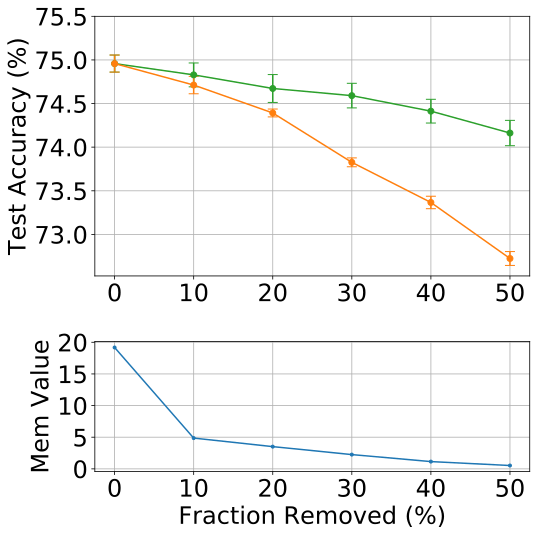

In [31]:
matplotlib.rcParams.update({'font.size': 24})

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

# sns.set_style("darkgrid")

x = range(0, 60, 10)

ax0.errorbar(x, random_mean_, 
            yerr=random_std_, 
            linestyle='-', 
            fmt='o', label='random', color='tab:green', capsize=5)
ax0.errorbar(x, mem_mean, 
            yerr=mem_std, 
            linestyle='-', fmt='o', label='memorized', color='tab:orange', capsize=5)

# ax0.legend()

ax0.set_ylabel('Test Accuracy (%)')
ax0.set_xticks(x)

ax0.set_yticks(np.arange(np.round(min(random_mean_+mem_mean), 0), np.round(max(random_mean_+mem_mean), 0)+1.0, 0.5))

ax0.grid(True)


ax1.set_xlabel('Fraction Removed (%)')
ax1.set_ylabel('Mem Value')
ax1.set_xticks(x)
ax1.set_yticks(np.arange(0, df_0['influence'].max()+5, 5))



ax1.plot(x, mem_list[0: len(x)], color='tab:blue', marker='.')
ax1.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

filename = "saved/vis/Marginal_Yahoo.pdf"
os.makedirs(os.path.dirname(filename), exist_ok=True)  

plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  